**Import Libraries and Setup Environment**

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import json
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from typing import Dict, List, Tuple, Optional, Union, Callable
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from dataclasses import dataclass
from tensorflow.keras import Model

In [2]:
print(f"TensorFlow version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
print(f"GPU Available: {len(gpus) > 0}")
if len(gpus) > 0:
    print(f"GPU Details: {gpus}")

TensorFlow version: 2.18.0
GPU Available: True
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
@dataclass
class Config:
    """Configuration for Improved TransGAN training and architecture"""
    z_dim = 128                                    # Dimension of the random noise vector input to the generator
    base_size = 4                                  # Initial spatial resolution (height and width) of the feature map
    learning_rate_g = 1e-4                         # Learning rate for the discriminator optimizer
    learning_rate_d = 1e-4                         # Learning rate for the discriminator optimizer
    beta1 = 0.5                                    # First momentum parameter for Adam optimizer
    beta2 = 0.999                                  # Second momentum parameter for Adam optimizer
    generator_steps = 1                            # Number of generator updates per iteration
    use_feature_matching = False                   # Whether to use feature matching loss
    use_historical_averaging = False               # Whether to use historical averaging of parameters
    use_minibatch_discrimination = False           # Whether to use minibatch discrimination
    feature_matching_weight = 1.0                  # Weight for the feature matching loss
    historical_averaging_weight = 0.1              # Weight for historical averaging penalty
    label_smoothing = 0.0                          # Amount of label smoothing for discriminator
    generator_target_prob = 0.9                    # Target probability for generator labels
    sample_freq = 1                                # Frequency of generating sample images during training
    save_freq = 10                                 # Frequency of saving model checkpoints
    checkpoint_dir = "./checkpoints"               # Directory to save model checkpoints
    sample_dir = "./samples"                       # Directory to save generated samples
    log_dir = "./logs"                             # Directory to save training logs
    batch_size = 64                                # Number of samples processed in each training step

### NOT shown in the config class: image_size: int = 32, dataset: str = 'cifar10'

@classmethod
def from_json(cls, json_path):
    """Load configuration from a JSON file"""
    with open(json_path, 'r') as f:
        config_dict = json.load(f)
    return cls(**config_dict)

def to_json(self, json_path):
    """Save configuration to a JSON file"""
    config_dict = {k: v for k, v in self.__dict__.items()}
    with open(json_path, 'w') as f:
        json.dump(config_dict, f, indent=2)

def __str__(self):
    """String representation of the configuration"""
    return '\n'.join(f"{k}: {v}" for k, v in self.__dict__.items())


In [5]:
@dataclass
class GANConfig:
    """Configuration for GAN training and architecture"""
    batch_size: int = 64                      # Number of samples processed in each training step
    z_dim: int = 100                          # Dimension of the random noise vector input to the generator
    learning_rate_d: float = 0.0002           # Learning rate for the discriminator optimizer
    learning_rate_g: float = 0.0002           # Learning rate for the generator optimizer
    beta1: float = 0.5                        # First momentum parameter for Adam optimizer
    beta2: float = 0.999                      # Second momentum parameter for Adam optimizer
    image_size: int = 32                      # Size of the generated images in pixels (32×32)
    channels: int = 3                         # Number of color channels in the images (RGB)
    use_feature_matching: bool = True         # Whether to use feature matching loss
    use_minibatch_discrimination: bool = True # Whether to use minibatch discrimination
    use_historical_averaging: bool = True     # Whether to use historical averaging of parameters
    use_virtual_batch_norm: bool = False      # Whether to use virtual batch normalization
    feature_matching_weight: float = 1.0      # Weight for the feature matching loss
    historical_averaging_weight: float = 0.0001 # Weight for historical averaging penalty
    label_smoothing: float = 0.1              # Amount of label smoothing for discriminator
    generator_target_prob: float = 0.65       # Target probability for generator labels
    dataset: str = 'cifar10'                  # Dataset to use for training
    epochs: int = 30                          # Number of training epochs
    save_freq: int = 5                        # Frequency of saving model checkpoints
    sample_freq: int = 1                      # Frequency of generating sample images
    log_freq: int = 5                         # Frequency of logging training metrics
    sample_size: int = 36                     # Number of samples to generate
    use_seed: int = 42                        # Random seed for reproducibility
    checkpoint_dir: str = 'checkpoints'       # Directory to save model checkpoints
    sample_dir: str = 'samples'               # Directory to save generated samples
    log_dir: str = 'logs'                     # Directory to save training logs
    generator_steps: int = 1                  # Number of generator updates per iteration
    discriminator_steps: int = 1              # Number of discriminator updates per iteration

    @classmethod
    def from_json(cls, json_path):
        """Load configuration from a JSON file"""
        with open(json_path, 'r') as f:
            config_dict = json.load(f)
        return cls(**config_dict)

    def to_json(self, json_path):
        """Save configuration to a JSON file"""
        config_dict = {k: v for k, v in self.__dict__.items()}
        with open(json_path, 'w') as f:
            json.dump(config_dict, f, indent=2)

    def __str__(self):
        """String representation of the configuration"""
        return '\n'.join(f"{k}: {v}" for k, v in self.__dict__.items())

In [6]:
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('samples', exist_ok=True)
os.makedirs('logs', exist_ok=True)

**Implementing the Core TransGAN Architectures**

This technique addresses the issue that traditional batch normalization makes the output of a layer dependent on all other instances in the same batch. Virtual batch normalization normalizes samples against a fixed reference batch for more stable training.

In [7]:
class VirtualBatchNormalization(layers.Layer):
    """Virtual Batch Normalization Layer"""

    def __init__(self, epsilon=1e-5, **kwargs):
        super(VirtualBatchNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon
        self.reference_batch_set = False

    def build(self, input_shape):
        self.ndim = len(input_shape)
        shape = [1] * self.ndim
        shape[-1] = input_shape[-1]

        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer=tf.random_normal_initializer(1.0, 0.02),
            name='gamma',
            trainable=True
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer=tf.zeros_initializer(),
            name='beta',
            trainable=True
        )

        self.ref_mean = self.add_weight(
            shape=shape,
            initializer=tf.zeros_initializer(),
            name='ref_mean',
            trainable=False
        )
        self.ref_var = self.add_weight(
            shape=shape,
            initializer=tf.ones_initializer(),
            name='ref_var',
            trainable=False
        )

        super(VirtualBatchNormalization, self).build(input_shape)

    def _get_axis(self):
        return list(range(self.ndim - 1))

    def set_reference_batch(self, x):
        axes = self._get_axis()
        mean = tf.reduce_mean(x, axis=axes, keepdims=True)
        var = tf.reduce_mean(tf.square(x - mean), axis=axes, keepdims=True)

        self.ref_mean.assign(mean)
        self.ref_var.assign(var)
        self.reference_batch_set = True

    def call(self, inputs, set_reference=False, **kwargs):
        if set_reference or not self.reference_batch_set:
            axes = self._get_axis()
            ref_mean = tf.reduce_mean(inputs, axis=axes, keepdims=True)
            ref_var = tf.reduce_mean(tf.square(inputs - ref_mean), axis=axes, keepdims=True)

            self.ref_mean.assign(ref_mean)
            self.ref_var.assign(ref_var)
            self.reference_batch_set = True

            batch_mean = ref_mean
            batch_var = ref_var
        else:
            axes = self._get_axis()
            batch_mean = tf.reduce_mean(inputs, axis=axes, keepdims=True)
            batch_var = tf.reduce_mean(tf.square(inputs - batch_mean), axis=axes, keepdims=True)

            batch_mean = 0.5 * (batch_mean + self.ref_mean)
            batch_var = 0.5 * (batch_var + self.ref_var)

        batch_var = tf.maximum(batch_var, self.epsilon)

        x_norm = (inputs - batch_mean) / tf.sqrt(batch_var)

        gamma_reshaped = self.gamma
        beta_reshaped = self.beta

        if self.ndim > 2:
            gamma_reshaped = tf.reshape(self.gamma, [1] * (self.ndim - 1) + [self.gamma.shape[0]])
            beta_reshaped = tf.reshape(self.beta, [1] * (self.ndim - 1) + [self.beta.shape[0]])

        return x_norm * gamma_reshaped + beta_reshaped

**EmbeddingProjection Layer**:

The EmbeddingProjection layer is designed to project random noise (latent vectors) into a structured feature space, transforming a 1D vector into a spatial feature map. This transformation is a crucial step in the generator of TransGAN, where convolutional layers are replaced with transformer-based architectures.

In [8]:
class EmbeddingProjection(tf.keras.Model):
    """Embedding Projection Layer"""
    def __init__(self, in_features, out_features, base_size):
        super(EmbeddingProjection, self).__init__()
        self.in_features = in_features
        self.base_size = base_size # Initial spatial resolution (height and width) of the feature map
        self.out_features = out_features
        self.fc = tf.keras.layers.Dense((self.base_size ** 2) * self.out_features, input_shape=(in_features,))

    def call(self, latents):
        flattened = self.fc(latents)
        return tf.reshape(flattened, (-1, self.base_size ** 2, self.out_features))

**GridAttention Layer**

The GridAttention layer is a self-attention mechanism designed for TransGAN. It follows the multi-head self-attention (MHSA) mechanism, where the input to this layer is a set of patch embeddings, then transformed into query ($Q$), key ($K$), and value ($V$) tensors, and the output is an updated set of embeddings after applying attention which is computed using dot-product interactions. By applying attention within structured feature maps, this layer enables spatially-aware self-attention, improving information flow and enabling the generator to capture local and global dependencies efficiently. Compared with normal multi-head self-attention, the grid attention mechanism limits the calculations to local regions to reduce the computational cost.

In [9]:
class GridAttention(Model):
    """Grid Attention Layer"""
    def __init__(self, embed_dim, num_heads, window_size, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., noise_enabled=False):
        super(GridAttention, self).__init__()

        self.num_heads = num_heads
        head_dim = embed_dim // num_heads
        self.scale = qk_scale if qk_scale is not None else head_dim ** -0.5
        self.window_size = window_size
        self.noise_enabled = noise_enabled

        self.qkv = layers.Dense(embed_dim * 3, use_bias=qkv_bias)
        self.attn_drop = layers.Dropout(attn_drop)
        self.proj = layers.Dense(embed_dim)
        self.proj_drop = layers.Dropout(proj_drop)

        if self.noise_enabled:
            self.noise_strength = self.add_weight(shape=(), initializer="zeros", trainable=True)

        if self.window_size:
            coords_h = tf.range(window_size)
            coords_w = tf.range(window_size)
            coords = tf.stack(tf.meshgrid(coords_h, coords_w, indexing='ij'))  # shape: (2, Wh, Ww)
            coords_flatten = tf.reshape(coords, (2, -1))  # shape: (2, Wh*Ww)
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # shape: (2, Wh*Ww, Wh*Ww)
            relative_coords = tf.transpose(relative_coords, (1, 2, 0))  # shape: (Wh*Ww, Wh*Ww, 2)
            relative_coords = tf.cast(relative_coords, dtype=tf.int32)
            relative_coords = relative_coords + (window_size - 1)
            relative_coords = relative_coords[:, :, 0] * (2 * window_size - 1) + relative_coords[:, :, 1]

            self.relative_position_index = tf.Variable(relative_coords, trainable=False, dtype=tf.int32)

            bias_table_shape = ((2 * window_size - 1) * (2 * window_size - 1), num_heads)
            self.relative_position_bias_table = self.add_weight(shape=bias_table_shape, initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02), trainable=True)

    def call(self, patch_embeddings, training=False):
        batch_size, n_tokens, embedding_dim = tf.shape(patch_embeddings)[0], tf.shape(patch_embeddings)[1], tf.shape(patch_embeddings)[2]

        if self.noise_enabled:
            noise = tf.random.normal((batch_size, n_tokens, 1)) * self.noise_strength
            patch_embeddings = patch_embeddings + noise

        qkv = self.qkv(patch_embeddings)  # (batch_size, n_tokens, 3 * embedding_dim)
        qkv = tf.reshape(qkv, (batch_size, n_tokens, 3, self.num_heads, embedding_dim // self.num_heads))
        qkv = tf.transpose(qkv, (2, 0, 3, 1, 4))  # (3, batch_size, num_heads, n_tokens, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = tf.matmul(q, k, transpose_b=True) * self.scale

        if self.window_size:
            relative_position_bias_index = tf.reshape(self.relative_position_index, [-1])
            relative_position_bias = tf.gather(self.relative_position_bias_table, relative_position_bias_index)
            relative_position_bias = tf.reshape(relative_position_bias, (self.window_size * self.window_size, self.window_size * self.window_size, -1))
            relative_position_bias = tf.transpose(relative_position_bias, (2, 0, 1))  # (num_heads, Wh*Ww, Wh*Ww)
            attn = attn + tf.expand_dims(relative_position_bias, axis=0)  # Broadcast across batch_size

        attn = tf.nn.softmax(attn, axis=-1)
        attn = self.attn_drop(attn, training=training)

        aggregated = tf.matmul(attn, v)
        aggregated = tf.transpose(aggregated, (0, 2, 1, 3))  # (batch_size, n_tokens, num_heads, head_dim)
        aggregated = tf.reshape(aggregated, (batch_size, n_tokens, embedding_dim))

        aggregated = self.proj(aggregated)
        aggregated = self.proj_drop(aggregated, training=training)

        return aggregated

The GridAttention Layer above works by:

1. Projects a sequence of patch embeddings (input)  into Query ($Q$), Key ($K$), and Value ($V$) tensors using a fully connected layer (Dense) to compute $Q$, $K$, and $V$ simultaneously.

2. Computes attention scores using scaled dot-product attention
   
   2.1 Performs matrix multiplication between $Q$ and $K$ to compute raw attention scores.

   2.2 Incorporates relative positional bias (if window_size is specified).

3. Retrieves learnable positional biases and adds them to the attention scores

4. Applies softmax normalization to obtain attention weights and uses attention weights to aggregate values across all patches.

5. Applies final projection and dropout

**EncoderBlock Layer**

The EncoderBlock is a transformer-based processing unit designed to refine patch embeddings using self-attention and feedforward layers. It operates as a basic building block for deep vision models, like GridAttention. By applying attention-based refinement and feedforward transformations, this layer helps encode spatial and contextual relationships, making it a crucial component for deep vision transformers.

In [10]:
class EncoderBlock(Model):
    """Transformer Encoder Block"""
    def __init__(self, d_model, n_heads, d_feedforward, window_size, dropout_rate=0, activation=None, noise_enabled=False):
        super(EncoderBlock, self).__init__()

        # Initialize the attention mechanism
        self.attention = GridAttention(d_model, n_heads, window_size, noise_enabled=noise_enabled)

        # First dense layer for the feedforward network
        self.feedforward_dense1 = layers.Dense(d_feedforward)
        # Set the activation function, default is GELU (Gaussian Error Linear Unit)
        self.activation = activation if callable(activation) else tf.nn.gelu ####  GELU

        # Dropout layer for regularization
        self.dropout1 = layers.Dropout(dropout_rate)
        # Second dense layer for the feedforward network
        self.feedforward_dense2 = layers.Dense(d_model)

        # Layer normalization to stabilize the learning
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, patch_embeddings, training=False):
        # Perform LayerNorm before calculation of attention
        attn_out = self.attention(self.norm1(patch_embeddings), training=training)
        patch_embeddings = patch_embeddings + attn_out  # Residual connection

        # Normalize and then apply the feedforward network
        ff_out = self.feedforward_dense1(self.norm2(patch_embeddings))
        ff_out = self.activation(ff_out)
        ff_out = self.dropout1(ff_out, training=training)
        ff_out = self.feedforward_dense2(ff_out)

        patch_embeddings = patch_embeddings + ff_out
        return patch_embeddings

This layer is structured similarly to a Transformer encoder:

1. First, applies self-attention to model relationships between patches.

2. Second, passes the embeddings through a feedforward network (MLP) for additional transformation.

3. Third, incorporates Layer Normalization (LayerNorm) and residual connections, ensuring stable gradient flow and improved convergence.

4. Forth, Optional dropout and activation functions provide regularization and non-linearity, enhancing generalization.

The input is a set of patch embeddings, and the output is an updated set of embeddings that have been refined through attention and feedforward transformations.

**StageBlock Layer**

The StageBlock serves as a higher-level processing unit in a transformer-based architecture. It is composed of multiple EncoderBlock layers, stacked together to progressively refine patch embeddings. Each EncoderBlock in the StageBlock applies self-attention and feedforward transformations, helping the model capture both local and global dependencies. By stacking multiple encoder blocks, StageBlock allows deeper feature extraction and hierarchical representation learning.

The input is a set of patch embeddings, and the output is a more refined set of embeddings after passing through multiple EncoderBlock layers.

In [11]:
class StageBlock(Model):
    """Transformer Stage Block"""
    def __init__(self, depth, num_heads, d_embeddings, d_ratio, window_size, activation=None, noise_enabled=False):
        super(StageBlock, self).__init__()

        # Create a list of EncoderBlock instances based on the specified depth
        self.blocks = [
            EncoderBlock(
                d_model=d_embeddings,
                n_heads=num_heads,
                d_feedforward=d_embeddings * d_ratio,
                window_size=window_size,
                activation=activation,
                noise_enabled=noise_enabled
            )
            for _ in range(depth)
        ]

    def call(self, patch_embeddings, training=False):
        # Execute each EncoderBlock sequentially
        for block in self.blocks:
            patch_embeddings = block(patch_embeddings, training=training)
        return patch_embeddings

StageBlock Lay works by:

1. Receives a sequence of patch embeddings (patch_embeddings) as input

2. Initializes multiple EncoderBlock layers
   
   2.1 Each block consists of: (1) Multi-head self-attention (via GridAttention). (2) Feedforward transformations (MLP). (3) Residual connections and normalization for stable training.

3. Sequentially processes embeddings through multiple encoder blocks

4. Outputs the final refined embeddings which retain hierarchical and contextual information

In [12]:
def pixel_shuffle(input_tensor, scale_factor):
    # Get the shape of the input tensor
    batch_size, height, width, channels = input_tensor.shape

    # Ensure the number of channels is divisible by scale_factor squared
    if channels % (scale_factor ** 2) != 0:
        raise ValueError("Channels must be divisible by scale_factor^2.")

    # Calculate the new number of channels
    new_channels = channels // (scale_factor ** 2)

    # Reshape the tensor to (N, H, W, r, r, C)
    reshaped_tensor = tf.reshape(input_tensor, (batch_size, height, width, scale_factor, scale_factor, new_channels))

    # Transpose to (N, H, r, W, r, C)
    transposed_tensor = tf.transpose(reshaped_tensor, [0, 1, 3, 2, 4, 5])

    # Final shape will be (N, H * r, W * r, C)
    output_tensor = tf.reshape(transposed_tensor, (batch_size, height * scale_factor, width * scale_factor, new_channels))

    return output_tensor

**Resampling Layer**

The Resampling layer is designed to adjust the spatial resolution of feature maps in TransGAN. It can perform both upsampling and downsampling, depending on the scale_factor. By dynamically adjusting feature map resolution, this layer allows the generator to process multi-scale representations effectively, ensuring smooth feature transitions during upsampling and downsampling.

If scale_factor > 1, it upsamples the feature map using Pixel Shuffle, which redistributes channel data into spatial dimensions.

If scale_factor < 1, it downsamples the feature map using Average Pooling, reducing spatial resolution while preserving information.

This layer ensures that the generator maintains spatial consistency as features are refined and upsampled to higher resolutions.

In [13]:
class Resampling(layers.Layer):
    def __init__(self, scale_factor):
        super(Resampling, self).__init__()
        self.scale_factor = scale_factor
        self.is_upsampling = scale_factor > 1

        # If not upsampling, set up Average Pooling for downsampling
        if not self.is_upsampling:
            self.resampling = layers.AveragePooling2D(pool_size=int(1 / scale_factor))  # 下采样

    def pixel_shuffle(self, input_tensor):
        """
        Pixel Shuffle operation, rearranges channel data into spatial dimensions.
        """
        batch_size, height, width, channels = tf.shape(input_tensor)[0], tf.shape(input_tensor)[1], \
                                              tf.shape(input_tensor)[2], tf.shape(input_tensor)[3]

        # Ensure channels are a multiple of scale_factor squared
        new_channels = channels // (self.scale_factor ** 2)

        reshaped_tensor = tf.reshape(input_tensor, (batch_size, height, width, self.scale_factor, self.scale_factor, new_channels))
        transposed_tensor = tf.transpose(reshaped_tensor, [0, 1, 3, 2, 4, 5])
        output_tensor = tf.reshape(transposed_tensor, (batch_size, height * self.scale_factor, width * self.scale_factor, new_channels))

        return output_tensor

    def call(self, embeddings, size=None):
        """
        Upsamples (Pixel Shuffle) or downsamples (Average Pooling) the input embeddings.
        """
        batch_size = tf.shape(embeddings)[0]
        embedding_dim = embeddings.shape[-1]  # ✅ 直接使用 `shape`，避免 `tf.Tensor` 计算错误
        size = tf.get_static_value(size) if isinstance(size, tf.Tensor) else size  # ✅ 解析 Tensor 为 Python `int`

        # Ensure embedding_dim is divisible by scale_factor squared
        tf.debugging.assert_equal(
            embedding_dim % (self.scale_factor ** 2),
            0,
            message=f"Embedding dim {embedding_dim} must be a multiple of scale_factor^2 ({self.scale_factor ** 2})!"
        )

        reduced_embedding_dim = embedding_dim // (self.scale_factor ** 2)

        # Reshape to (batch, size, size, embedding_dim)
        feature_maps = tf.reshape(embeddings, (batch_size, size, size, embedding_dim))

        if self.is_upsampling:
            # Perform Pixel Shuffle for upsampling
            resampled = self.pixel_shuffle(feature_maps)
            new_size = size * self.scale_factor
        else:
            # Perform Average Pooling for downsampling and reshape accordingly
            resampled = self.resampling(tf.transpose(feature_maps, (0, 3, 1, 2)))  # 转换到 NCHW 格式
            resampled = tf.transpose(resampled, (0, 2, 3, 1))  # 转换回 NHWC 格式
            new_size = size // self.scale_factor

        # Ensure embedding dimension is correct after resampling
        n_tokens_new = new_size * new_size
        feature_maps = tf.reshape(resampled, (batch_size, n_tokens_new, reduced_embedding_dim))

        return tf.transpose(feature_maps, (0, 1, 2)), new_size  # 返回 (batch, n_tokens_new, embedding_dim)

Resampling Lay works by:

1. Receives a set of patch embeddings and a scale_factor as input and Determines whether to upsample or downsample
   
   1.1 If scale_factor > 1, $Pixel Shuffle$ function is used to increase resolution which can converts the channel dimension into spatial resolution. Then the output resolution increases from ($H$, $W$) to ($H$ * $scale\_ factor$, $W$ * $scale\_ factor$)
   
   1.2 If scale_factor < 1, $Average Pooling$ is used to reduce resolution which can reduce resolution from ($H$, $W$) to ($H$ / $scale_factor$, $W$ / $scale_factor$). Besides, layers.AveragePooling2D will be used to preserve feature integrity while reducing size

2. Reshapes the output to maintain token structure.
   
   2.1 The spatially adjusted feature map is reshaped back into a structured token sequence.

   2.2 The number of tokens updates based on the new spatial size.

**Generator**

The Generator model is designed as a transformer-based generator for image synthesis, following the structure of TransGAN. Unlike traditional CNN-based GANs, this generator leverages self-attention mechanisms instead of convolutional layers to progressively refine feature maps. By leveraging transformers, progressive upsampling, and spatial self-attention, this generator enables high-quality image synthesis while preserving long-range dependencies and global coherence.

The key components of this generator include:

1. Embedding Projection: Maps a random latent vector to an initial spatial feature map.

2. Virtual Batch Normalization (VBN): Stabilizes feature distributions across batches.

3. Positional Encoding: Provides spatial awareness to the self-attention mechanism.

3. Transformer Encoder Blocks: Captures global dependencies and refines feature representations.

4. Resampling Layer: Upsamples feature maps progressively to increase resolution.

5. Output Projection: Uses a Conv2D layer to generate the final image, applying a tanh activation to normalize pixel values.

This generator takes a random latent vector as input and outputs a synthetic image with values in the range [-1, 1].

In [ ]:
class Generator(Model):
    def __init__(self, base_size=8, n_colors=3, embed_dim=1024, depths=(5, 4, 2), num_heads=4, ff_ratio=4, latent_dim=256):
        super(Generator, self).__init__()

        self.base_size = base_size
        self.embed_dim = embed_dim

        # Embedding layer: Projects the noise vector into feature space
        self.embedding_projection = EmbeddingProjection(latent_dim, embed_dim, base_size)
        self.vbn = VirtualBatchNormalization()  # Include Virtual Batch Normalization

        self.n_stages = len(depths)

        # Positional embeddings: Provide spatial context to embeddings
        self.positional_embeddings = [
            self.add_weight(
                shape=(1, (self.base_size * (2 ** index)) ** 2, embed_dim // (4 ** index)),
                initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                trainable=True,
                name=f'pos_embedding_{index}'
            ) for index in range(self.n_stages)
        ]

        # Upsampling layer
        self.upsampling = Resampling(scale_factor=2)

        # Transformer
        self.stages = [
            StageBlock(
                depth,
                num_heads,
                d_ratio=ff_ratio,
                window_size=base_size * (2 ** index),
                d_embeddings=embed_dim // (4 ** index),
            ) for index, depth in enumerate(depths)
        ]

        # Output projection: Convolution layer + tanh activation
        self.output_projection = layers.Conv2D(n_colors, kernel_size=1, activation="tanh", data_format="channels_last")

        # Initialize reference batch
        self.reference_batch = None

    def call(self, latents, training=False, set_reference=False):

        # 1. Initial embedding from latent vectors
        patch_embeddings = self.embedding_projection(latents, training=training)
        size = self.base_size

        # 2. Set reference batch (used only at the start of training)
        if set_reference or self.reference_batch is None:
            self.reference_batch = patch_embeddings

        # 3. Normalize using Virtual Batch Normalization
        patch_embeddings = self.vbn(patch_embeddings, set_reference=set_reference)

        # print(f"Initial patch_embeddings shape: {patch_embeddings.shape}")

        # 4. Pass through Transformer encoding blocks sequentially
        for index, stage in enumerate(self.stages):
            patch_embeddings += self.positional_embeddings[index]  # Add positional encoding
            patch_embeddings = stage(patch_embeddings, training=training)

            # 5. Upsample (only execute in the first few layers)
            if index < self.n_stages - 1:
                patch_embeddings, size = self.upsampling(patch_embeddings, size=size)
                # print(f"After Resampling stage {index}: {patch_embeddings.shape}, size: {size}")

        # 6. Reshape to Feature Map (N, H, W, C)
        batch_size = tf.shape(patch_embeddings)[0]
        feature_maps = tf.reshape(patch_embeddings, (batch_size, size, size, -1))
        # print(f"Feature maps before output projection: {feature_maps.shape}")

        # 7. Project through Conv2D to ensure output range is [-1, 1]
        output = self.output_projection(feature_maps)
        output = tf.clip_by_value(output, -1.0, 1.0)
        # print(f"Output shape after projection: {output.shape}")

        return output

In [15]:
class MinibatchDiscrimination(layers.Layer):
    """Minibatch Discrimination layer to prevent mode collapse"""
    def __init__(self, num_kernels=100, dim_per_kernel=5):
        super(MinibatchDiscrimination, self).__init__()
        self.num_kernels = num_kernels  # Number of kernels for feature extraction
        self.dim_per_kernel = dim_per_kernel  # Dimensionality of features per kernel

    def build(self, input_shape):
        # Initialize weight matrix for the layer
        self.W = self.add_weight(
            shape=(input_shape[-1], self.num_kernels * self.dim_per_kernel),
            initializer="random_normal",
            trainable=True
        )

    def call(self, inputs):
        """Compute Minibatch features"""
        x = tf.matmul(inputs, self.W)  # Matrix multiplication (batch, num_kernels * dim_per_kernel)
        x = tf.reshape(x, (-1, self.num_kernels, self.dim_per_kernel))

        # Calculate L1 distance between feature vectors
        diff = tf.expand_dims(x, axis=3) - tf.expand_dims(tf.transpose(x, [1, 2, 0]), axis=0)
        abs_diff = tf.reduce_sum(tf.abs(diff), axis=2)

        # Compute Minibatch features based on the distances
        minibatch_features = tf.reduce_sum(tf.exp(-abs_diff), axis=2)

        # Concatenate original inputs with the minibatch features
        return tf.concat([inputs, minibatch_features], axis=1)

**TransformerBlock**

The TransformerBlock is an encoder module inspired by the Transformer architecture, primarily used in Vision Transformers (ViTs), TransGAN, and NLP models. It processes input embeddings through self-attention and feedforward layers, refining feature representations while maintaining global contextual dependencies. By leveraging self-attention, feedforward transformations, and residual connections, the TransformerBlock allows the model to learn complex feature relationships, making it an essential building block for vision transformers, TransGAN, and other deep learning architectures. The TransformerBlock is crucial for enabling the generator or other transformer-based architectures to effectively model long-range dependencies.

In [16]:
class TransformerBlock(layers.Layer):
    """ Transformer Encoder Block"""
    def __init__(self, embed_dim, num_heads, ff_dim=512, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()

        # 1. Multi-head self-attention mechanism
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.norm1 = layers.LayerNormalization()   # Layer normalization for the attention output
        self.dropout1 = layers.Dropout(dropout_rate)   # Dropout for regularization

        # 2. Feedforward neural network (MLP)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="gelu"),  # First dense layer with GeLU activation
            layers.Dense(embed_dim)  # Second dense layer to project back to the embedding dimension
        ])
        self.norm2 = layers.LayerNormalization()   # Layer normalization for MLP output
        self.dropout2 = layers.Dropout(dropout_rate)  # Dropout for the feedforward output

    def call(self, inputs):
        """Forward pass"""
        attn_output = self.attention(inputs, inputs)  # Self-attention mechanism
        attn_output = self.dropout1(attn_output)  # Apply dropout to attention output
        out1 = self.norm1(inputs + attn_output)  # Residual connection + normalization

        ffn_output = self.ffn(out1)  # Pass through feedforward network (MLP)
        ffn_output = self.dropout2(ffn_output)  # Apply dropout to MLP output
        return self.norm2(out1 + ffn_output)  # Residual connection + normalization

This block contains:

1. Multi-Head Self-Attention (MHA): Captures relationships between input tokens.

2. Feedforward Network (FFN): Enhances feature representations after attention.

3. Layer Normalization (LayerNorm): Stabilizes training by normalizing activations.

4. Residual Connections: Helps retain original information and improve gradient flow.

5. Dropout Regularization: Prevents overfitting by adding noise during training.

**TransformerDiscriminator Layer**

The TransformerDiscriminator is a transformer-based discriminator designed to distinguish between real and generated images. Unlike traditional CNN-based discriminators, this model processes images using self-attention mechanisms instead of convolutional layers, allowing it to capture global dependencies and long-range interactions. By leveraging self-attention, transformer-based processing, and minibatch discrimination, the TransformerDiscriminator provides a powerful alternative to traditional CNN-based discriminators, making it highly effective in GAN architectures like TransGAN.

This discriminator follows a Vision Transformer (ViT)-like structure, consisting of:

1. Patch Embedding Layer: Converts input images into a sequence of patch tokens.

2. Transformer Encoder Blocks: Processes the patch embeddings using self-attention.

3. Minibatch Discrimination (optional): Helps prevent mode collapse by introducing diversity-sensitive features.

4. Normalization & MLP Classification Head: Outputs a real/fake probability score using a sigmoid activation function.

The model takes an image as input and outputs a single probability indicating whether the input is real or fake.

In [17]:
class TransformerDiscriminator(tf.keras.Model):
    """ Transformer-based Discriminator """

    def __init__(self, img_size=32, embed_dim=512, num_heads=4, depth=4, patch_size=4, use_minibatch=True):
        super(TransformerDiscriminator, self).__init__()

        self.img_size = img_size   # Size of the input image 32× 32
        self.patch_size = patch_size  # Size of each patch
        self.use_minibatch = use_minibatch  # Indicates whether to use minibatch discrimination

        # 1️. Patch Embedding layer: divides the image into patches and projects them into a high-dimensional space
        self.patch_embedding = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, padding="same")
        self.flatten = layers.Reshape((-1, embed_dim))  # Flatten to create Transformer tokens

        # 2️. Transformer Encoder
        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads) for _ in range(depth)
        ]

        # 3️. Minibatch Discrimination (if enabled)
        if self.use_minibatch:
            self.minibatch_layer = MinibatchDiscrimination(num_kernels=100, dim_per_kernel=5)

        # 4️. Normalization layer & MLP output head
        self.norm = layers.LayerNormalization()   # Normalize features before final output
        self.mlp_head = layers.Dense(1, activation="sigmoid")  # Output layer for predicting real/fake

    def call(self, inputs, training=False, return_features=False):
        """
        Forward pass: if `return_features=True`, returns (output, features), otherwise just returns output.
        """
        batch_size = tf.shape(inputs)[0]  # Get the batch size

        # Normalize image to the range [-1, 1]
        inputs = (inputs - 0.5) * 2

        # Patch Embedding
        x = self.patch_embedding(inputs)  # (B, H, W, C) after convolution
        h, w, c = tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]  # Get height, width, and channels
        x = tf.reshape(x, [batch_size, h * w, c])  # (B, num_patches, embed_dim)


        # Transformer Encoder
        for block in self.transformer_blocks:
            x = block(x)

        # Average Pooling to get features
        features = tf.reduce_mean(x, axis=1)

        # Minibatch Discrimination
        if self.use_minibatch:
            features = self.minibatch_layer(features)

        # MLP Classification head
        x = self.norm(features)
        output = self.mlp_head(x)

        if return_features:
            return output, features  # Return both classification result and features
        else:
            return output  # Only return classification result

In [18]:
# Feature Matching
class FeatureMatching:
    def __call__(self, real_features, fake_features):
        real_mean = tf.reduce_mean(real_features, axis=0)
        fake_mean = tf.reduce_mean(fake_features, axis=0)
        return tf.reduce_mean(tf.square(real_mean - fake_mean))

# Historical Averaging
class HistoricalAveraging:
    def __init__(self, beta=0.99):
        self.beta = beta
        self.parameter_history = {}

    def initialize_if_needed(self, model):
        for weight in model.trainable_weights:
            if weight.name not in self.parameter_history:
                self.parameter_history[weight.name] = weight.numpy()

    def __call__(self, model, weight=0.01):
        if not self.parameter_history:
            return tf.constant(0.0)

        total_loss = 0.0
        for curr_weight in model.trainable_weights:
            name = curr_weight.name
            if name not in self.parameter_history:
                continue
            hist_tensor = tf.convert_to_tensor(self.parameter_history[name], dtype=curr_weight.dtype)
            diff = curr_weight - hist_tensor
            loss = tf.reduce_sum(tf.square(diff))
            total_loss += loss
        return weight * total_loss

    def update_history(self, model):
        for weight in model.trainable_weights:
            name = weight.name
            if name in self.parameter_history:
                self.parameter_history[name] = self.beta * self.parameter_history[name] + (1 - self.beta) * weight.numpy()

**ImprovedTransGAN Model**

The ImprovedTransGAN class implements a Transformer-based Generative Adversarial Network (GAN) with several enhancements for stability and performance. Unlike traditional convolutional GANs, this model leverages self-attention mechanisms to capture long-range dependencies in image generation. By incorporating these techniques, ImprovedTransGAN achieves more stable training, higher-quality image synthesis, and improved generalization compared to traditional GANs.

TransGAN Architecture:

1. GridAttention-Based Generator: Uses transformers(GridAttention Block layers) instead of convolutional layers for better spatial understanding.

2. Transformer-Based Discriminator: Processes image patches as tokens for superior global feature extraction.


This implementation includes three major improvements over the TransGAN:

1. Feature Matching – Improves training stability by aligning real and generated feature distributions.

2. Historical Averaging – Stabilizes parameter updates by maintaining a history of model weights.

3. Virtual Batch Normalization (VBN) – Normalizes activations using a fixed reference batch for improved generalization.

In [ ]:
class ImprovedTransGAN:
    """ Improved TransGAN Model
    This class implements the Improved TransGAN architecture 
    Features:
    - Generator: Transformer-based generator with embedding projection and upsampling
    - Discriminator: Transformer-based discriminator with minibatch discrimination
    - Feature Matching: Loss function to improve generator training
    - Historical Averaging: Regularization technique to stabilize training
    - Virtual Batch Normalization: Normalization technique to improve convergence
    """

    def __init__(self, config):
        self.config = config
        self.generator = Generator(
            base_size=config.base_size,
            n_colors=3,
            embed_dim=1024,
            depths=(5, 4, 2),
            num_heads=4,
            ff_ratio=4,
            latent_dim=config.z_dim
        )
        self.discriminator = TransformerDiscriminator(config)

        self.feature_matching = FeatureMatching()
        self.historical_averaging = HistoricalAveraging(beta=0.99)

        self.gen_optimizer = tf.keras.optimizers.Adam(config.learning_rate_g, beta_1=config.beta1, beta_2=config.beta2)
        self.disc_optimizer = tf.keras.optimizers.Adam(config.learning_rate_d, beta_1=config.beta1, beta_2=config.beta2)

        os.makedirs(config.sample_dir, exist_ok=True)
        os.makedirs(config.checkpoint_dir, exist_ok=True)


        self.fixed_noise = tf.random.normal([16, config.z_dim])
        print("TransGAN model initialized!!!!!")

        self.gen_losses = []
        self.disc_losses = []
        self.real_scores = []
        self.fake_scores = []
        self.real_accs = []   ###########
        self.fake_accs = []   ###########


    def generator_loss(self, fake_output, real_features=None, fake_features=None):
        target = tf.ones_like(fake_output) * self.config.generator_target_prob
        gen_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(target, fake_output, from_logits=True))

        if self.config.use_feature_matching:
            fm_loss = self.feature_matching(real_features, fake_features)
            gen_loss += self.config.feature_matching_weight * fm_loss

        if self.config.use_historical_averaging:
            ha_loss = self.historical_averaging(self.generator, self.config.historical_averaging_weight)
            gen_loss += ha_loss

        return gen_loss

    def discriminator_loss(self, real_output, fake_output):
        real_labels = tf.ones_like(real_output) * (1.0 - self.config.label_smoothing)
        fake_labels = tf.zeros_like(fake_output)

        real_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, real_output, from_logits=True))
        fake_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(fake_labels, fake_output, from_logits=True))
        disc_loss = real_loss + fake_loss

        if self.config.use_historical_averaging:
            ha_loss = self.historical_averaging(self.discriminator, self.config.historical_averaging_weight)
            disc_loss += ha_loss

        return disc_loss

    @tf.function
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        noise = tf.random.normal([batch_size, self.config.z_dim])

        with tf.GradientTape() as disc_tape:
            fake_images = self.generator(noise, training=True)
            real_output, real_features = self.discriminator(real_images, training=True, return_features=True)
            fake_output, fake_features = self.discriminator(fake_images, training=True, return_features=True)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))
        # self.historical_averaging.update_history(self.discriminator)

        tf.py_function(
            func = lambda: self.historical_averaging.update_history(self.discriminator),
            inp = [],  # No input needed for this function
            Tout = []  # No output needed for this function
        )

        real_score = tf.reduce_mean(real_output)
        fake_score = tf.reduce_mean(fake_output)

        gen_loss = 0.0
        for _ in range(self.config.generator_steps):
            noise = tf.random.normal([self.config.batch_size, self.config.z_dim]) ############################3

            with tf.GradientTape() as gen_tape:
                fake_images = self.generator(noise, training=True)
                fake_output, fake_features = self.discriminator(fake_images, training=True, return_features=True)
                curr_gen_loss = self.generator_loss(fake_output, real_features, fake_features)
                gen_loss += curr_gen_loss

            gen_gradients = gen_tape.gradient(curr_gen_loss, self.generator.trainable_variables)
            self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

            tf.py_function(
            func = lambda: self.historical_averaging.update_history(self.generator),
            inp = [],  # No input needed for this function
            Tout = []  # No output needed for this function
        )
    

        gen_loss = gen_loss / self.config.generator_steps

        real_sigmoid = tf.sigmoid(real_output)
        fake_sigmoid = tf.sigmoid(fake_output)
        real_acc = tf.reduce_mean(tf.cast(real_sigmoid > 0.5, tf.float32))  # Accuracy for real images
        fake_acc = tf.reduce_mean(tf.cast(fake_sigmoid < 0.5, tf.float32))  # Accuracy for fake images

        real_score = tf.reduce_mean(real_sigmoid)
        fake_score = tf.reduce_mean(fake_sigmoid)


        return {
            "gen_loss": gen_loss,
            "disc_loss": disc_loss,
            "real_score": real_score,
            "fake_score": fake_score,
            "real_acc": real_acc,
            "fake_acc": fake_acc
        }



    def train(self, dataset, epochs):

        start_time = time.time()

        if self.config.use_historical_averaging:
            self.historical_averaging.initialize_if_needed(self.generator)
            self.historical_averaging.initialize_if_needed(self.discriminator)


        for epoch in range(epochs):
            epoch_start = time.time()

            progress_bar = tqdm(total=len(list(dataset)))
            progress_bar.set_description(f"Epoch {epoch+1}/{epochs}")

            epoch_gen_losses = []
            epoch_disc_losses = []
            epoch_real_scores = []
            epoch_fake_scores = []
            epoch_real_accs = []
            epoch_fake_accs = []

            for batch in dataset:
                metrics = self.train_step(batch)

                if self.config.use_historical_averaging:
                    self.historical_averaging.update_history(self.generator)
                    self.historical_averaging.update_history(self.discriminator)

                epoch_gen_losses.append(metrics["gen_loss"].numpy())
                epoch_disc_losses.append(metrics["disc_loss"].numpy())
                epoch_real_scores.append(metrics["real_score"].numpy())
                epoch_fake_scores.append(metrics["fake_score"].numpy())
                epoch_real_accs.append(metrics["real_acc"].numpy())
                epoch_fake_accs.append(metrics["fake_acc"].numpy())

                progress_bar.update(1)
                desc = f"Epoch {epoch+1}/{epochs} - "
                desc += f"G: {metrics['gen_loss']:.4f}, D: {metrics['disc_loss']:.4f}, "
                desc += f"D(x): {metrics['real_score']:.4f}, D(G(z)): {metrics['fake_score']:.4f}"
                progress_bar.set_description(desc)

            progress_bar.close()

            avg_gen_loss = np.mean(epoch_gen_losses)
            avg_disc_loss = np.mean(epoch_disc_losses)
            avg_real_score = np.mean(epoch_real_scores)
            avg_fake_score = np.mean(epoch_fake_scores)
            avg_real_acc = np.mean(epoch_real_accs)
            avg_fake_acc = np.mean(epoch_fake_accs)

            self.gen_losses.append(avg_gen_loss)
            self.disc_losses.append(avg_disc_loss)
            self.real_scores.append(avg_real_score)
            self.fake_scores.append(avg_fake_score)
            self.real_accs.append(avg_real_acc)
            self.fake_accs.append(avg_fake_acc)

            if (epoch + 1) % self.config.sample_freq == 0:
                self.generate_and_save_images(epoch + 1)

            if (epoch + 1) % self.config.save_freq == 0:
                self.save_checkpoint(epoch + 1)

            epoch_time = time.time() - epoch_start
            print(f"Epoch {epoch+1}/{epochs} completed in {epoch_time:.2f}s")
            print(f"Generator Loss: {avg_gen_loss:.4f}")
            print(f"Discriminator Loss: {avg_disc_loss:.4f}")
            print(f"D(x): {avg_real_score:.4f}, D(G(z)): {avg_fake_score:.4f}")
            print(f"Real Acc: {avg_real_acc:.4f}, Fake Acc: {avg_fake_acc:.4f}")
            print("-" * 80)

        total_time = time.time() - start_time
        print(f"Training completed in {total_time/60:.2f} minutes")

        self.plot_training_history()



    def generate_and_save_images(self, epoch):
        predictions = self.generator(self.fixed_noise, training=False)

        fig, axes = plt.subplots(4, 4, figsize=(8, 8))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            img = (predictions[i].numpy() + 1) / 2.0
            plt.imshow(img)
            plt.axis("off")

        plt.suptitle(f"Generated Images - Epoch {epoch}")
        plt.tight_layout()
        plt.savefig(f"{self.config.sample_dir}/epoch_{epoch}.png")
        plt.close()


    def plot_training_history(self):
        """Plot the training history of generator and discriminator losses"""

        epochs = range(1, len(self.gen_losses) + 1)

        plt.figure(figsize=(15, 10)) ################


        # Subplot 1: Losses for Generator and Discriminator
        plt.subplot(2, 2, 1)
        plt.plot(epochs, self.gen_losses, label="Generator Loss")
        plt.plot(epochs, self.disc_losses, label="Discriminator Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Generator and Discriminator Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Subplot 2: Discriminator Scores
        plt.subplot(2, 2, 2)
        plt.plot(epochs, self.real_scores, label="D(x) - Real")
        plt.plot(epochs, self.fake_scores, label="D(G(z)) - Fake")
        plt.xlabel("Epochs")
        plt.ylabel("Score")
        plt.title("Discriminator Scores")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f"{self.config.sample_dir}/training_history.png")
        plt.show()

        # Subplot 3: Discriminator Accuracy
        plt.subplot(2, 2, 3)
        plt.plot(epochs, self.real_accs, label='Real Accuracy')
        plt.plot(epochs, self.fake_accs, label='Fake Accuracy')
        plt.title('Discriminator Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Subplot 4: Display Generated Images as a Single Composite Image
        plt.subplot(2, 2, 4)
        predictions = self.generator(self.fixed_noise, training=False)

        grid_size = 4
        image_size = predictions.shape[1]

        composite_image = np.zeros((grid_size * image_size, grid_size * image_size, 3))

        for i in range(grid_size):
            for j in range(grid_size):
                idx = i * grid_size + j
                if idx < predictions.shape[0]:
                    img = (predictions[idx].numpy() + 1) / 2.0
                    composite_image[i * image_size:(i + 1) * image_size, j * image_size:(j + 1) * image_size, :] = img

        plt.imshow(composite_image)
        plt.axis('off')
        plt.title('Generated Images')

        plt.suptitle('GAN Training Progress', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(f"{self.config.log_dir}/training_history.png")
        plt.show()

    def save_checkpoint(self, epoch):
        checkpoint_dir = os.path.join(self.config.checkpoint_dir, f"checkpoint_epoch_{epoch}")
        os.makedirs(checkpoint_dir, exist_ok=True)
        
        self.generator.save_weights(os.path.join(checkpoint_dir, "generator.weights.h5"))
        self.discriminator.save_weights(os.path.join(checkpoint_dir, "discriminator.weights.h5"))

    def load_checkpoint(self, epoch):
        checkpoint_dir = os.path.join(self.config.checkpoint_dir, f"checkpoint_epoch_{epoch}")

        self.generator.load_weights(os.path.join(checkpoint_dir, "generator.weights.h5"))
        self.discriminator.load_weights(os.path.join(checkpoint_dir, "discriminator.weights.h5"))

        print(f"Checkpoint loaded from epoch {epoch}")

The ImprovedTransGAN Model Runs like these:

🔹 Step 1: Model Initialization

Sets up the generator, discriminator, optimizers, additional stabilization techniques. And loads advanced training features.

1.6 Creates directories for model checkpoints and sample images

1.7 Generates fixed noise samples for evaluation during training.

🔹 Step 2: Training Loop Execution

1. Processes real images in mini-batches.

2. Performs a discriminator update: (1) Uses multi-head self-attention to analyze image patches. (2)Includes Minibatch Discrimination (optional) to prevent mode collapse.

3. Performs multiple generator updates (generator_steps): (1)Uses self-attention instead of CNN layers. (2)Projects latent noise into a structured spatial feature map. (3)Incorporates Virtual Batch Normalization (VBN) for training stability.

4. Configures advanced training techniques: (1)Feature Matching: Ensures feature distributions of real and fake images are similar. (2)Historical Averaging: Uses past model weights to stabilize learning.

5. Sets up optimizers (Adam) for both networks: (1)Separate learning rates for generator and discriminator. (2)Uses momentum parameters (beta1, beta2) for stable updates.

6. Logs training performance.

7. Generates sample images every sample_freq epochs.

8. Saves checkpoints every save_freq epochs.

🔹 Step 3: Evaluating Model Performance

1. Plots training loss curves and discriminator confidence scores.

2. Generates synthetic images to monitor improvements.

**FIDEvaluator**

The FIDEvaluator class is designed to evaluate the performance of a Generative Adversarial Network (GAN) by calculating the Fréchet Inception Distance (FID). The FID score is a widely used metric to measure the similarity between real and generated images, helping assess the quality of synthetic data. By leveraging InceptionV3 to extract meaningful image features, it provides a robust and reliable measure of image realism. This metric is fundamental in improving and benchmarking GAN-based image generation models.

The key idea behind FID is to compare the distributions of real and generated images in a high-level feature space extracted using a pre-trained InceptionV3 model.

In [20]:
class FIDEvaluator:
    """Evaluates GAN performance using Fréchet Inception Distance (FID).
    FID measures the similarity between generated and real image distributions
    using features extracted from a pre-trained InceptionV3 model."""

    def __init__(self, config):
        self.config = config
        self.batch_size = config.batch_size

        self.inception_model = tf.keras.applications.InceptionV3(
            include_top=False,
            pooling='avg',
            weights='imagenet',
            input_shape=(299, 299, 3)
        )

        self.real_features = None
        self.real_mean = None
        self.real_cov = None

        print("FID Evaluator initialized")

    def preprocess_images(self, images):
        images = (images + 1) / 2.0
        images = tf.image.resize(images, (299, 299))
        images = tf.keras.applications.inception_v3.preprocess_input(images * 255.0)
        return images

    def extract_features(self, images):
        features = self.inception_model.predict(images, batch_size=self.batch_size)
        return features

    def compute_real_statistics(self, dataset, num_samples=10000):
        print(f"Computing real data statistics using {num_samples} samples...")

        real_images = []
        for batch in dataset:
            for img in batch:
                real_images.append(img.numpy())
            if len(real_images) >= num_samples:
                break

        real_images = np.array(real_images[:num_samples])
        processed_images = self.preprocess_images(real_images)

        features = []
        batch_size = self.batch_size
        for i in range(0, len(processed_images), batch_size):
            batch = processed_images[i:i+batch_size]
            batch_features = self.extract_features(batch)
            features.append(batch_features)

        self.real_features = np.concatenate(features, axis=0)

        self.real_mean = np.mean(self.real_features, axis=0)
        self.real_cov = np.cov(self.real_features, rowvar=False)

        print(f"Real data statistics calculated from {len(self.real_features)} images")

        return self.real_mean, self.real_cov

    def calculate_fid(self, generator, num_samples=10000):
        if self.real_mean is None or self.real_cov is None:
            raise ValueError("Real statistics not computed. Run compute_real_statistics first.")

        print(f"Calculating FID score using {num_samples} generated samples...")

        z_dim = self.config.z_dim
        batch_size = self.batch_size
        num_batches = int(np.ceil(num_samples / batch_size))

        fake_images = []
        for i in range(num_batches):
            current_batch_size = min(batch_size, num_samples - i * batch_size)
            z = tf.random.normal([current_batch_size, z_dim])
            generated_batch = generator(z, training=False)
            fake_images.append(generated_batch)

        fake_images = np.concatenate(fake_images, axis=0)[:num_samples]
        processed_images = self.preprocess_images(fake_images)

        fake_features = []
        for i in range(0, len(processed_images), batch_size):
            batch = processed_images[i:i+batch_size]
            batch_features = self.extract_features(batch)
            fake_features.append(batch_features)

        fake_features = np.concatenate(fake_features, axis=0)

        fake_mean = np.mean(fake_features, axis=0)
        fake_cov = np.cov(fake_features, rowvar=False)

        from scipy import linalg

        mean_diff_squared = np.sum((self.real_mean - fake_mean) ** 2)
        covmean = linalg.sqrtm(self.real_cov.dot(fake_cov))

        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = mean_diff_squared + np.trace(self.real_cov + fake_cov - 2 * covmean)

        print(f"FID Score: {fid:.4f} (lower is better)")

        return fid

    def evaluate_with_samples(self, real_images, fake_images, num_samples=10000):
        real_samples = real_images[:num_samples]
        fake_samples = fake_images[:num_samples]

        processed_real = self.preprocess_images(real_samples)
        processed_fake = self.preprocess_images(fake_samples)

        batch_size = self.batch_size

        real_features = []
        for i in range(0, len(processed_real), batch_size):
            batch = processed_real[i:i+batch_size]
            batch_features = self.extract_features(batch)
            real_features.append(batch_features)
        real_features = np.concatenate(real_features, axis=0)

        fake_features = []
        for i in range(0, len(processed_fake), batch_size):
            batch = processed_fake[i:i+batch_size]
            batch_features = self.extract_features(batch)
            fake_features.append(batch_features)
        fake_features = np.concatenate(fake_features, axis=0)

        real_mean = np.mean(real_features, axis=0)
        real_cov = np.cov(real_features, rowvar=False)

        fake_mean = np.mean(fake_features, axis=0)
        fake_cov = np.cov(fake_features, rowvar=False)

        from scipy import linalg

        mean_diff_squared = np.sum((real_mean - fake_mean) ** 2)
        covmean = linalg.sqrtm(real_cov.dot(fake_cov))

        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = mean_diff_squared + np.trace(real_cov + fake_cov - 2 * covmean)

        print(f"FID Score: {fid:.4f} (lower is better)")

        return fid

In [21]:
# Function to run experiments for ImprovedTransGAN
def run_transgan_experiment(config, dataset, epochs=10, evaluate_every=5):
    print("=== Starting TransGAN Experiment ===")
    print(f"Configuration: {config.__dict__}")
    print(f"Training for {epochs} epochs, evaluating every {evaluate_every} epochs")

    # Initialize the FID evaluator and compute statistics for real images
    fid_evaluator = FIDEvaluator(config)
    fid_evaluator.compute_real_statistics(dataset, num_samples=1000)

    # Initialize the ImprovedTransGAN model
    gan = ImprovedTransGAN(config)
    fid_scores = []   # List to store FID scores for evaluation

    # Create log directory for storing results
    os.makedirs(config.log_dir, exist_ok=True)

    for epoch in range(epochs):
        print(f"\n=== Epoch {epoch+1}/{epochs} ===")
        gan.train(dataset, 1)   # Train the GAN for one epoch

        # Periodically evaluate FID
        if (epoch + 1) % evaluate_every == 0 or epoch == epochs - 1:
            print(f"Evaluating FID after epoch {epoch+1}")
            fid = fid_evaluator.calculate_fid(gan.generator, num_samples=1000)
            fid_scores.append((epoch + 1, fid))

    # Final FID evaluation
    print("\n=== Final Evaluation ===")
    final_fid = fid_evaluator.calculate_fid(gan.generator, num_samples=2000)

    # Plot FID scores over training epochs
    if len(fid_scores) > 0:
        plt.figure(figsize=(10, 6))
        epochs_, scores = zip(*fid_scores)  # Unzip epoch and score tuples
        plt.plot(epochs_, scores, 'o-', linewidth=2)  # Plot the FID scores
        plt.title('FID Score Over Training (Lower is Better)')
        plt.xlabel('Epochs')
        plt.ylabel('FID Score')
        plt.grid(True, alpha=0.3)
        plt.savefig(f"{config.log_dir}/fid_history.png")
        plt.show()

    # Display final generated samples
    final_samples = 36  # Number of samples to generate
    noise = tf.random.normal([final_samples, config.z_dim])  # Generate random noise vectors
    generated_images = gan.generator(noise, training=False)  # Generate images from noise

    plt.figure(figsize=(10, 10))
    for i in range(final_samples):
        plt.subplot(6, 6, i+1)  # Create a grid for displaying generated images
        img = (generated_images[i].numpy() + 1) / 2.0
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Final Generated Samples (FID: {final_fid:.4f})')
    plt.tight_layout()
    plt.savefig(f"{config.log_dir}/final_samples.png")
    plt.show()

    return gan, fid_scores, final_fid

In [ ]:
import itertools

def visualize_comparison_results(results):
    print("Creating comparative visualizations...")

    # Automatically assign colors for different configurations
    default_colors = itertools.cycle(['gray', 'blue', 'green', 'orange', 'purple', 'red', 'cyan', 'magenta'])
    colors = {name: next(default_colors) for name in results}

    # --- FID Bar Chart ---
    plt.figure(figsize=(12, 6))


    names = list(results.keys())
    fid_scores = [results[name]["fid"] for name in names]



    sorted_indices = np.argsort(fid_scores)
    sorted_names = [names[i] for i in sorted_indices]
    sorted_fids = [fid_scores[i] for i in sorted_indices]
    sorted_colors = [colors[name] for name in sorted_names]

    plt.barh(sorted_names, sorted_fids, color=sorted_colors)
    plt.title('FID Score Comparison (Lower is Better)')
    plt.xlabel('FID Score')
    plt.grid(axis='x', alpha=0.3)

    for i, v in enumerate(sorted_fids):
        plt.text(v + 0.5, i, f"{v:.2f}", va='center')

    plt.tight_layout()
    plt.savefig("fid_comparison.png", dpi=150)
    plt.show()

    # --- Loss Curve Comparison ---

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    for name in results:
        if hasattr(results[name]["gan"], "gen_losses"):
            plt.plot(results[name]["gan"].gen_losses, label=name, color=colors[name], linewidth=2)
    
    plt.title('Generator Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    for name in results:
        if hasattr(results[name]["gan"], "disc_losses"):
            plt.plot(results[name]["gan"].disc_losses, label=name, color=colors[name], linewidth=2)
    
    plt.title('Discriminator Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)


    plt.suptitle('Training Loss Comparison Across Techniques', fontsize=16)
    plt.tight_layout()
    plt.savefig("loss_comparison.png", dpi=150)
    plt.show()

    # --- Discriminator Score Comparison ---
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    for name in results:
        if hasattr(results[name]["gan"], "real_scores"):
            plt.plot(results[name]["gan"].real_scores, label=name, color=colors[name], linewidth=2)
    
    plt.title('D(x) - Real Score Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    for name in results:
        if hasattr(results[name]["gan"], "fake_scores"):
            plt.plot(results[name]["gan"].fake_scores, label=name, color=colors[name], linewidth=2)
    
    plt.title('D(G(z)) - Fake Score Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)


    plt.suptitle('Discriminator Score Comparison', fontsize=16)
    plt.tight_layout()
    plt.savefig("score_comparison.png", dpi=150)
    plt.show()

    configs_to_show = min(6, len(results))
    fixed_noise = tf.random.normal([16, 100])

    # --- Output generated images for each model ---
    for name, result in results.items():
        config = result["config"]
        z_dim = config.z_dim
        fixed_noise = tf.random.normal([16, z_dim])

        # Generate images using the generator of the current model
        generated_images = result["gan"].generator(fixed_noise, training=False)

        plt.figure(figsize=(8, 8))
        plt.suptitle(f"{name.replace('_', ' ').title()} (FID: {result['fid']:.2f})", fontsize=14)

        for j in range(16):
            plt.subplot(4, 4, j+1)
            img = (generated_images[j].numpy() + 1) / 2.0
            plt.imshow(img)
            plt.axis('off')

        save_path = os.path.join(config.log_dir, f"samples_{name}.png")
        plt.tight_layout()
        plt.savefig(save_path, dpi=150)
        plt.show()

    # --- Output summary table of results ---
    print("\nSummary of Results:")
    print("-" * 100)
    print(f"{'Configuration':<20} {'FID Score':<12} {'Gen Loss':<12} {'Disc Loss':<12} {'D(x)':<12} {'D(G(z))':<12}")
    print("-" * 100)

    sorted_results = sorted(results.items(), key=lambda x: x[1]["fid"])

    for name, result in sorted_results:
        print(f"{name:<20} {result['fid']:<12.4f} ", end="")
        print(f"{result.get('gen_loss', 'N/A'):<12.4f} " if result.get('gen_loss') is not None else f"{'N/A':<12} ", end="")
        print(f"{result.get('disc_loss', 'N/A'):<12.4f} " if result.get('disc_loss') is not None else f"{'N/A':<12} ", end="")
        print(f"{result.get('real_score', 'N/A'):<12.4f} " if result.get('real_score') is not None else f"{'N/A':<12} ", end="")
        print(f"{result.get('fake_score', 'N/A'):<12.4f}" if result.get('fake_score') is not None else f"{'N/A':<12}")

    print("-" * 100)

In [ ]:
class TransGANConfig:
    def __init__(self):
        self.z_dim = 128  # Dimension of the latent space (noise vector)
        self.base_size = 4  # Base size for generator and discriminator (must be set)
        self.learning_rate_g = 1e-4  # Learning rate for the generator
        self.learning_rate_d = 1e-4  # Learning rate for the discriminator
        self.beta1 = 0.5  # Adam optimizer beta1 parameter
        self.beta2 = 0.999  # Adam optimizer beta2 parameter
        self.generator_steps = 1  # Number of generator updates per discriminator update

        self.use_feature_matching = False  # Flag for enabling feature matching
        self.use_historical_averaging = False  # Flag for enabling historical averaging
        self.feature_matching_weight = 1.0  # Weight for the feature matching loss
        self.historical_averaging_weight = 0.1  # Weight for the historical averaging loss

        self.label_smoothing = 0.0  # Smoothing factor for labels to help with training
        self.generator_target_prob = 0.9 # Target probability for generator outputs

        self.sample_freq = 1 # Frequency of generating samples
        self.save_freq = 5  # Frequency of saving checkpoints

        self.sample_dir = "./samples" # Directory for saving generated samples
        self.checkpoint_dir = "./checkpoints" # Directory for saving model checkpoints
        self.log_dir = "./logs" # Directory for saving training logs

        self.batch_size = 64  # ⚠️ Used for FIDEvaluator


def compare_transgan_improvements(dataset, base_epochs=5):
    print("=== TransGAN Improvement Comparison Study ===")

    # List of different configurations for comparison
    configs = [
        {
            "name": "baseline",
            "updates": {
                "use_feature_matching": False,
                "use_historical_averaging": False,
                "label_smoothing": 0.0
            }
        },
        {
            "name": "feature_matching",
            "updates": {
                "use_feature_matching": True,
                "use_historical_averaging": False,
                "label_smoothing": 0.0
            }
        },
        {
            "name": "historical_avg",
            "updates": {
                "use_feature_matching": False,
                "use_historical_averaging": True,
                "label_smoothing": 0.0
            }
        },
        {
            "name": "label_smoothing",
            "updates": {
                "use_feature_matching": False,
                "use_historical_averaging": False,
                "label_smoothing": 0.1
            }
        },
        {
            "name": "all_improvements",
            "updates": {
                "use_feature_matching": True,
                "use_historical_averaging": True,
                "label_smoothing": 0.1
            }
        }
    ]

    base_config = TransGANConfig() # Initialize the base configuration
    fid_evaluator = FIDEvaluator(base_config) # Initialize the FID evaluator
    fid_evaluator.compute_real_statistics(dataset, num_samples=1000) # Compute statistics for real images

    results = {}  # Dictionary to store results for each configuration

    for config_info in configs:
        name = config_info["name"]  # Get the configuration name
        updates = config_info["updates"]  # Get the configuration updates

        print(f"\n\n=== Training Configuration: {name} ===")
        print("Settings:") ###############

        config = TransGANConfig()
        for k, v in updates.items():
            setattr(config, k, v)

        config.sample_dir = f"samples/{name}"
        config.checkpoint_dir = f"checkpoints/{name}"
        config.log_dir = f"logs/{name}"

        os.makedirs(config.sample_dir, exist_ok=True)
        os.makedirs(config.checkpoint_dir, exist_ok=True)
        os.makedirs(config.log_dir, exist_ok=True)

        gan = ImprovedTransGAN(config)
        gan.train(dataset, base_epochs)

        fid_score = fid_evaluator.calculate_fid(gan.generator, num_samples=1000)

        results[name] = {
            "fid": fid_score,
            "gan": gan,
            "config": config,
            "gen_loss": gan.gen_losses[-1] if gan.gen_losses else None,
            "disc_loss": gan.disc_losses[-1] if gan.disc_losses else None,
            "real_score": gan.real_scores[-1] if gan.real_scores else None,
            "fake_score": gan.fake_scores[-1] if gan.fake_scores else None
        }

        np.savez(
            f"{config.log_dir}/metrics.npz",
            gen_losses=np.array(gan.gen_losses),
            disc_losses=np.array(gan.disc_losses),
            real_scores=np.array(gan.real_scores),
            fake_scores=np.array(gan.fake_scores),
            fid=np.array([fid_score])
        )

    visualize_comparison_results(results)

    return results

In [ ]:
import itertools

def visualize_comparison_results(results):
    print("Creating comparative visualizations...")

    # Automatically assign colors for different configurations
    default_colors = itertools.cycle(['gray', 'blue', 'green', 'orange', 'purple', 'red', 'cyan', 'magenta'])
    colors = {name: next(default_colors) for name in results}

    # --- FID Bar Chart ---
    plt.figure(figsize=(12, 6))


    names = list(results.keys())
    fid_scores = [results[name]["fid"] for name in names]



    sorted_indices = np.argsort(fid_scores)
    sorted_names = [names[i] for i in sorted_indices]
    sorted_fids = [fid_scores[i] for i in sorted_indices]
    sorted_colors = [colors[name] for name in sorted_names]

    plt.barh(sorted_names, sorted_fids, color=sorted_colors)
    plt.title('FID Score Comparison (Lower is Better)')
    plt.xlabel('FID Score')
    plt.grid(axis='x', alpha=0.3)

    for i, v in enumerate(sorted_fids):
        plt.text(v + 0.5, i, f"{v:.2f}", va='center')

    plt.tight_layout()
    plt.savefig("fid_comparison.png", dpi=150)
    plt.show()

    # --- Loss Curve Comparison ---

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    for name in results:
        if hasattr(results[name]["gan"], "gen_losses"):
            plt.plot(results[name]["gan"].gen_losses, label=name, color=colors[name], linewidth=2)
    
    plt.title('Generator Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    for name in results:
        if hasattr(results[name]["gan"], "disc_losses"):
            plt.plot(results[name]["gan"].disc_losses, label=name, color=colors[name], linewidth=2)
    
    plt.title('Discriminator Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)


    plt.suptitle('Training Loss Comparison Across Techniques', fontsize=16)
    plt.tight_layout()
    plt.savefig("loss_comparison.png", dpi=150)
    plt.show()

    # --- Discriminator Score Comparison ---
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    for name in results:
        if hasattr(results[name]["gan"], "real_scores"):
            plt.plot(results[name]["gan"].real_scores, label=name, color=colors[name], linewidth=2)
    
    plt.title('D(x) - Real Score Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    for name in results:
        if hasattr(results[name]["gan"], "fake_scores"):
            plt.plot(results[name]["gan"].fake_scores, label=name, color=colors[name], linewidth=2)
    
    plt.title('D(G(z)) - Fake Score Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)


    plt.suptitle('Discriminator Score Comparison', fontsize=16)
    plt.tight_layout()
    plt.savefig("score_comparison.png", dpi=150)
    plt.show()

    configs_to_show = min(6, len(results))
    fixed_noise = tf.random.normal([16, 100])

    # --- Output generated images for each model ---
    for name, result in results.items():
        config = result["config"]
        z_dim = config.z_dim
        fixed_noise = tf.random.normal([16, z_dim])

        # Generate images using the generator of the current model
        generated_images = result["gan"].generator(fixed_noise, training=False)

        plt.figure(figsize=(8, 8))
        plt.suptitle(f"{name.replace('_', ' ').title()} (FID: {result['fid']:.2f})", fontsize=14)

        for j in range(16):
            plt.subplot(4, 4, j+1)
            img = (generated_images[j].numpy() + 1) / 2.0
            plt.imshow(img)
            plt.axis('off')

        save_path = os.path.join(config.log_dir, f"samples_{name}.png")
        plt.tight_layout()
        plt.savefig(save_path, dpi=150)
        plt.show()

    # --- Output summary table of results ---
    print("\nSummary of Results:")
    print("-" * 100)
    print(f"{'Configuration':<20} {'FID Score':<12} {'Gen Loss':<12} {'Disc Loss':<12} {'D(x)':<12} {'D(G(z))':<12}")
    print("-" * 100)

    sorted_results = sorted(results.items(), key=lambda x: x[1]["fid"])

    for name, result in sorted_results:
        print(f"{name:<20} {result['fid']:<12.4f} ", end="")
        print(f"{result.get('gen_loss', 'N/A'):<12.4f} " if result.get('gen_loss') is not None else f"{'N/A':<12} ", end="")
        print(f"{result.get('disc_loss', 'N/A'):<12.4f} " if result.get('disc_loss') is not None else f"{'N/A':<12} ", end="")
        print(f"{result.get('real_score', 'N/A'):<12.4f} " if result.get('real_score') is not None else f"{'N/A':<12} ", end="")
        print(f"{result.get('fake_score', 'N/A'):<12.4f}" if result.get('fake_score') is not None else f"{'N/A':<12}")

    print("-" * 100)

In [24]:
# Dummy config class that includes a z_dim attribute for testing purposes
class DummyConfig:
    def __init__(self, z_dim=100):
        self.z_dim = z_dim
        self.log_dir = "./logs"

# Dummy GAN class to simulate the structure of a real GAN for testing
class DummyGAN:
    def __init__(self):
        self.gen_losses = [np.random.uniform(2.0, 3.0) for _ in range(3)]
        self.disc_losses = [np.random.uniform(1.0, 2.0) for _ in range(3)]
        self.real_scores = [np.random.uniform(0.6, 0.8) for _ in range(3)]
        self.fake_scores = [np.random.uniform(0.2, 0.4) for _ in range(3)]
        self.generator = lambda z, training=False: tf.random.uniform([z.shape[0], 16, 16, 3], -1, 1)

In [ ]:
def analyze_mode_collapse(results, dataset, num_samples=1000):

    print("Analyzing mode collapse across configurations...")

    # Collect real images from the dataset
    real_images = []

    for batch in dataset:
        for img in batch:
            real_images.append(img.numpy())
        if len(real_images) >= num_samples:
            break

    real_images = np.array(real_images[:num_samples])

    # Initialize InceptionV3 model for feature extraction
    inception_model = tf.keras.applications.InceptionV3(
        include_top=False,
        pooling='avg',
        weights='imagenet'
    )

    # Function to preprocess images for the Inception model
    def preprocess_images(images):
        images = (images + 1) / 2.0
        images = tf.image.resize(images, (299, 299))
        images = tf.keras.applications.inception_v3.preprocess_input(images * 255.0)
        return images

    # Preprocess real images and extract features using Inception model
    processed_real = preprocess_images(real_images)
    real_features = inception_model.predict(processed_real, batch_size=32, verbose=0)

    feature_stats = {}

    # Loop through results to analyze each configuration
    for name, result in results.items():
        config = result["config"]
        z = tf.random.normal([num_samples, config.z_dim])
        fake_images = result["gan"].generator(z, training=False).numpy()

        # Preprocess generated images and extract features
        processed_fake = preprocess_images(fake_images)
        fake_features = inception_model.predict(processed_fake, batch_size=32, verbose=0)

        # Store feature statistics for generated images
        feature_stats[name] = {
            "features": fake_features,
            "mean": np.mean(fake_features, axis=0),
            "std": np.std(fake_features, axis=0),
            "min": np.min(fake_features, axis=0),
            "max": np.max(fake_features, axis=0)
        }


    feature_diversity = {}
    for name, stats in feature_stats.items():
        avg_std = np.mean(stats["std"])
        avg_range = np.mean(stats["max"] - stats["min"])

        feature_diversity[name] = {
            "avg_std": avg_std,
            "avg_range": avg_range
        }

    # Calculate statistics for real images
    real_std = np.mean(np.std(real_features, axis=0))
    real_range = np.mean(np.max(real_features, axis=0) - np.min(real_features, axis=0))

    # Plot feature diversity
    plt.figure(figsize=(12, 6))

    names = list(feature_diversity.keys())
    avg_stds = [feature_diversity[name]["avg_std"] for name in names]

    # Sort feature diversities in descending order
    sorted_indices = np.argsort(avg_stds)[::-1]
    sorted_names = [names[i] for i in sorted_indices]
    sorted_stds = [avg_stds[i] for i in sorted_indices]

    # Assign colors to configurations for plotting
    colors = {
        'baseline': 'gray',
        'feature_matching': 'blue',
        'minibatch_disc': 'green',
        'historical_avg': 'purple',
        'label_smoothing': 'orange',
        'all_improvements': 'red'
    }
    sorted_colors = [colors.get(name, 'skyblue') for name in sorted_names]

    plt.bar(sorted_names, sorted_stds, color=sorted_colors)
    plt.axhline(y=real_std, color='black', linestyle='--', label=f'Real Data ({real_std:.4f})')

    plt.title('Feature Diversity Comparison (Higher is Better)')
    plt.ylabel('Average Feature Standard Deviation')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    for i, v in enumerate(sorted_stds):
        plt.text(i, v + 0.001, f"{v:.4f}", ha='center')

    plt.tight_layout()
    plt.savefig("feature_diversity.png", dpi=150)
    plt.show()

    print("\nMode Collapse Analysis:")
    print("-" * 80)
    print(f"{'Configuration':<20} {'Feature Std':<15} {'% of Real':<15} {'Mode Collapse':<15}")
    print("-" * 80)

    sorted_results = sorted(feature_diversity.items(), key=lambda x: x[1]["avg_std"], reverse=True)

    for name, stats in sorted_results:
        avg_std = stats["avg_std"]
        pct_of_real = (avg_std / real_std) * 100

        if pct_of_real >= 90:
            collapse_status = "Minimal"
        elif pct_of_real >= 70:
            collapse_status = "Minor"
        elif pct_of_real >= 50:
            collapse_status = "Moderate"
        elif pct_of_real >= 30:
            collapse_status = "Significant"
        else:
            collapse_status = "Severe"

        print(f"{name:<20} {avg_std:<15.4f} {pct_of_real:<15.2f}% {collapse_status:<15}")

    print("-" * 80)
    print(f"Real Data Reference: {real_std:.4f}")
    print("-" * 80)

In [ ]:
def generate_summary_report(results, dataset_name, epochs):
    """Generate a summary report of the experiment results."""


    print("\n=== Comprehensive Experiment Summary ===")
    print(f"Dataset: {dataset_name}")
    print(f"Training epochs per configuration: {epochs}")
    print("-" * 80)

    best_config = min(results.items(), key=lambda x: x[1]["fid"])
    worst_config = max(results.items(), key=lambda x: x[1]["fid"])

    print(f"Best configuration: {best_config[0]} (FID: {best_config[1]['fid']:.4f})")
    print(f"Worst configuration: {worst_config[0]} (FID: {worst_config[1]['fid']:.4f})")
    print(f"Improvement: {(worst_config[1]['fid'] - best_config[1]['fid']) / worst_config[1]['fid'] * 100:.2f}%")

    print("\n=== Impact of Individual Techniques ===")

    baseline_fid = results["baseline"]["fid"]

    techniques = ["feature_matching", "minibatch_disc", "historical_avg", "label_smoothing"]

    for technique in techniques:
        if technique in results:
            technique_fid = results[technique]["fid"]
            improvement = (baseline_fid - technique_fid) / baseline_fid * 100

            print(f"{technique.replace('_', ' ').title()}:")
            print(f"  FID: {technique_fid:.4f}")
            print(f"  Improvement over baseline: {improvement:.2f}%")

    if "all_improvements" in results:
        all_fid = results["all_improvements"]["fid"]
        all_improvement = (baseline_fid - all_fid) / baseline_fid * 100

        print(f"\nAll Improvements Combined:")
        print(f"  FID: {all_fid:.4f}")
        print(f"  Improvement over baseline: {all_improvement:.2f}%")

    print("\n=== Conclusions ===")

    technique_improvements = []

    for technique in techniques:
        if technique in results:
            technique_fid = results[technique]["fid"]
            improvement = (baseline_fid - technique_fid) / baseline_fid * 100
            technique_improvements.append((technique, improvement))

    technique_improvements.sort(key=lambda x: x[1], reverse=True)

    print("Technique effectiveness ranking:")
    for i, (technique, improvement) in enumerate(technique_improvements):
        print(f"  {i+1}. {technique.replace('_', ' ').title()}: {improvement:.2f}% improvement")

    print("-" * 80)
    print("Experiment complete!")

In [ ]:
def run_complete_experiment(epochs=10, dataset_name='cifar10'):
    """Run a complete experiment with TransGAN on CIFAR-10 dataset."""

    print(f"=== Starting Complete TransGAN Experiment ===")
    print(f"Dataset: {dataset_name}")
    print(f"Training epochs: {epochs}")

    class Config:
        z_dim = 128
        base_size = 4
        learning_rate_g = 1e-4
        learning_rate_d = 1e-4
        beta1 = 0.5
        beta2 = 0.999
        generator_steps = 1
        use_feature_matching = False
        use_historical_averaging = False
        use_minibatch_discrimination = False  # optional
        feature_matching_weight = 1.0
        historical_averaging_weight = 0.1
        label_smoothing = 0.0
        generator_target_prob = 0.9
        sample_freq = 1
        save_freq = 10
        checkpoint_dir = "./checkpoints"
        sample_dir = "./samples"
        log_dir = "./logs"
        batch_size = 64

    config = Config()

    # Load CIFAR10 and use only 10% of the data
    (x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

    # Use only 10% of the data
    x_train = x_train[:int(0.2 * len(x_train))]
    y_train = y_train[:int(0.2 * len(y_train))]

    dataset = tf.data.Dataset.from_tensor_slices(x_train)

    def preprocess_image(img):
        img = tf.image.resize(img, [32, 32])
        img = tf.cast(img, tf.float32)
        img = (img - 127.5) / 127.5
        return img

    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(10000)
    dataset = dataset.batch(config.batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)


    start_time = time.time()

    results = compare_transgan_improvements(dataset, base_epochs=epochs)

    analyze_mode_collapse(results, dataset)

    total_time = time.time() - start_time
    print(f"\nTotal experiment time: {total_time/60:.2f} minutes")

    generate_summary_report(results, dataset_name, epochs)

    return results

=== Starting Complete TransGAN Experiment ===
Dataset: cifar10
Training epochs: 30
=== TransGAN Improvement Comparison Study ===
FID Evaluator initialized
Computing real data statistics using 1000 samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Real data statistics calculated from 1000 images


=== Training Configuration: baseline ===
  use_feature_matching: False
  use_historical_averaging: False
  label_smoothing: 0.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TransGAN model initialized!!!!!
Initial patch_embeddings shape: (64, 16, 1024)
After Resampling stage 0: (64, 64, 256), size: 8
After Resampling stage 1: (64, 256, 64), size: 16
Feature maps before output projection: (64, 16, 16, 64)
Output shape after projection: (64, 16, 16, 3)
Initial patch_embeddings shape: (64, 16, 1024)
After Resampling stage 0: (64, 64, 256), size: 8
After Resampling stage 1: (64, 256, 64), size: 16
Feature maps before output projection: (64, 16, 16, 64)
Output shape after projection: (64, 16, 16, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_discriminator', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Initial patch_embeddings shape: (64, 16, 1024)
After Resampling stage 0: (64, 64, 256), size: 8
After Resampling stage 1: (64, 256, 64), size: 16
Feature maps before output projection: (64, 16, 16, 64)
Output shape after projection: (64, 16, 16, 3)
Initial patch_embeddings shape: (64, 16, 1024)
After Resampling stage 0: (64, 64, 256), size: 8
After Resampling stage 1: (64, 256, 64), size: 16
Feature maps before output projection: (64, 16, 16, 64)
Output shape after projection: (64, 16, 16, 3)
Initial patch_embeddings shape: (64, 16, 1024)
After Resampling stage 0: (64, 64, 256), size: 8
After Resampling stage 1: (64, 256, 64), size: 16
Feature maps before output projection: (64, 16, 16, 64)
Output shape after projection: (64, 16, 16, 3)
Epoch 1/30 - G_Loss: 5.0451, D_Loss: 0.0045
Initial patch_embeddings shape: (16, 16, 1024)
After Resampling stage 0: (16, 64, 256), size: 8
After Resampling stage 1: (16, 256, 64), size: 16
Feature maps before output projection: (16, 16, 16, 64)
Output 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_discriminator_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Initial patch_embeddings shape: (64, 16, 1024)
After Resampling stage 0: (64, 64, 256), size: 8
After Resampling stage 1: (64, 256, 64), size: 16
Feature maps before output projection: (64, 16, 16, 64)
Output shape after projection: (64, 16, 16, 3)
Initial patch_embeddings shape: (64, 16, 1024)
After Resampling stage 0: (64, 64, 256), size: 8
After Resampling stage 1: (64, 256, 64), size: 16
Feature maps before output projection: (64, 16, 16, 64)
Output shape after projection: (64, 16, 16, 3)
Initial patch_embeddings shape: (64, 16, 1024)
After Resampling stage 0: (64, 64, 256), size: 8
After Resampling stage 1: (64, 256, 64), size: 16
Feature maps before output projection: (64, 16, 16, 64)
Output shape after projection: (64, 16, 16, 3)
Epoch 1/30 - G_Loss: 27.0638, D_Loss: 0.0054
Initial patch_embeddings shape: (16, 16, 1024)
After Resampling stage 0: (16, 64, 256), size: 8
After Resampling stage 1: (16, 256, 64), size: 16
Feature maps before output projection: (16, 16, 16, 64)
Output

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_discriminator_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Initial patch_embeddings shape: (64, 16, 1024)
After Resampling stage 0: (64, 64, 256), size: 8
After Resampling stage 1: (64, 256, 64), size: 16
Feature maps before output projection: (64, 16, 16, 64)
Output shape after projection: (64, 16, 16, 3)
Initial patch_embeddings shape: (64, 16, 1024)
After Resampling stage 0: (64, 64, 256), size: 8
After Resampling stage 1: (64, 256, 64), size: 16
Feature maps before output projection: (64, 16, 16, 64)
Output shape after projection: (64, 16, 16, 3)
Initial patch_embeddings shape: (64, 16, 1024)
After Resampling stage 0: (64, 64, 256), size: 8
After Resampling stage 1: (64, 256, 64), size: 16
Feature maps before output projection: (64, 16, 16, 64)
Output shape after projection: (64, 16, 16, 3)
Epoch 1/30 - G_Loss: 6.5091, D_Loss: 0.0022
Initial patch_embeddings shape: (16, 16, 1024)
After Resampling stage 0: (16, 64, 256), size: 8
After Resampling stage 1: (16, 256, 64), size: 16
Feature maps before output projection: (16, 16, 16, 64)
Output 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_discriminator_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Initial patch_embeddings shape: (64, 16, 1024)
After Resampling stage 0: (64, 64, 256), size: 8
After Resampling stage 1: (64, 256, 64), size: 16
Feature maps before output projection: (64, 16, 16, 64)
Output shape after projection: (64, 16, 16, 3)
Initial patch_embeddings shape: (64, 16, 1024)
After Resampling stage 0: (64, 64, 256), size: 8
After Resampling stage 1: (64, 256, 64), size: 16
Feature maps before output projection: (64, 16, 16, 64)
Output shape after projection: (64, 16, 16, 3)
Initial patch_embeddings shape: (64, 16, 1024)
After Resampling stage 0: (64, 64, 256), size: 8
After Resampling stage 1: (64, 256, 64), size: 16
Feature maps before output projection: (64, 16, 16, 64)
Output shape after projection: (64, 16, 16, 3)
Epoch 1/30 - G_Loss: 6.6489, D_Loss: 0.3273
Initial patch_embeddings shape: (16, 16, 1024)
After Resampling stage 0: (16, 64, 256), size: 8
After Resampling stage 1: (16, 256, 64), size: 16
Feature maps before output projection: (16, 16, 16, 64)
Output 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_discriminator_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Initial patch_embeddings shape: (64, 16, 1024)
After Resampling stage 0: (64, 64, 256), size: 8
After Resampling stage 1: (64, 256, 64), size: 16
Feature maps before output projection: (64, 16, 16, 64)
Output shape after projection: (64, 16, 16, 3)
Initial patch_embeddings shape: (64, 16, 1024)
After Resampling stage 0: (64, 64, 256), size: 8
After Resampling stage 1: (64, 256, 64), size: 16
Feature maps before output projection: (64, 16, 16, 64)
Output shape after projection: (64, 16, 16, 3)
Initial patch_embeddings shape: (64, 16, 1024)
After Resampling stage 0: (64, 64, 256), size: 8
After Resampling stage 1: (64, 256, 64), size: 16
Feature maps before output projection: (64, 16, 16, 64)
Output shape after projection: (64, 16, 16, 3)
Epoch 1/30 - G_Loss: 29.0757, D_Loss: 0.3263
Initial patch_embeddings shape: (16, 16, 1024)
After Resampling stage 0: (16, 64, 256), size: 8
After Resampling stage 1: (16, 256, 64), size: 16
Feature maps before output projection: (16, 16, 16, 64)
Output

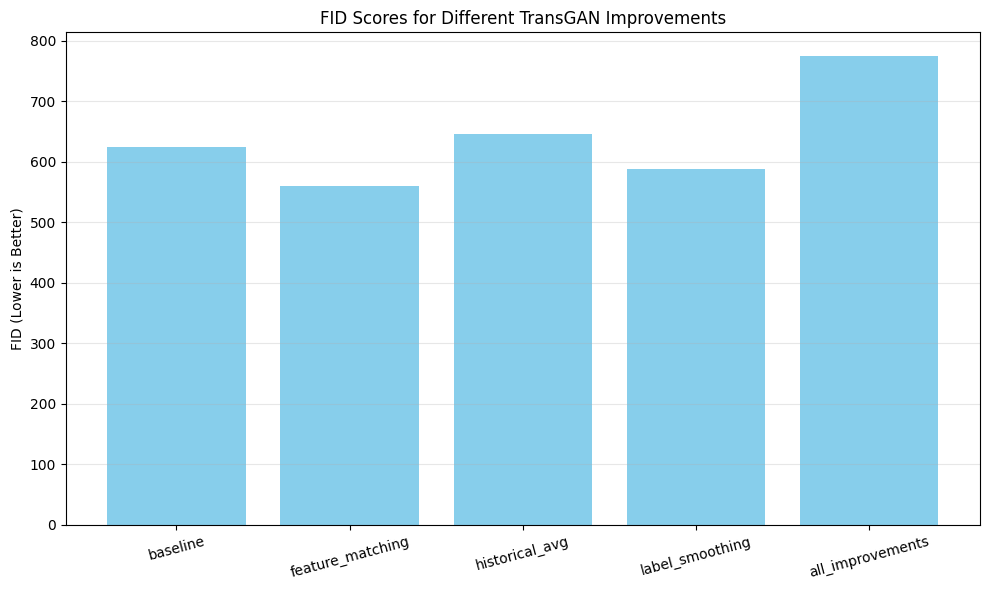

Analyzing mode collapse across configurations...
Initial patch_embeddings shape: (1000, 16, 1024)
After Resampling stage 0: (1000, 64, 256), size: 8
After Resampling stage 1: (1000, 256, 64), size: 16
Feature maps before output projection: (1000, 16, 16, 64)
Output shape after projection: (1000, 16, 16, 3)
Initial patch_embeddings shape: (1000, 16, 1024)
After Resampling stage 0: (1000, 64, 256), size: 8
After Resampling stage 1: (1000, 256, 64), size: 16
Feature maps before output projection: (1000, 16, 16, 64)
Output shape after projection: (1000, 16, 16, 3)
Initial patch_embeddings shape: (1000, 16, 1024)
After Resampling stage 0: (1000, 64, 256), size: 8
After Resampling stage 1: (1000, 256, 64), size: 16
Feature maps before output projection: (1000, 16, 16, 64)
Output shape after projection: (1000, 16, 16, 3)
Initial patch_embeddings shape: (1000, 16, 1024)
After Resampling stage 0: (1000, 64, 256), size: 8
After Resampling stage 1: (1000, 256, 64), size: 16
Feature maps before ou

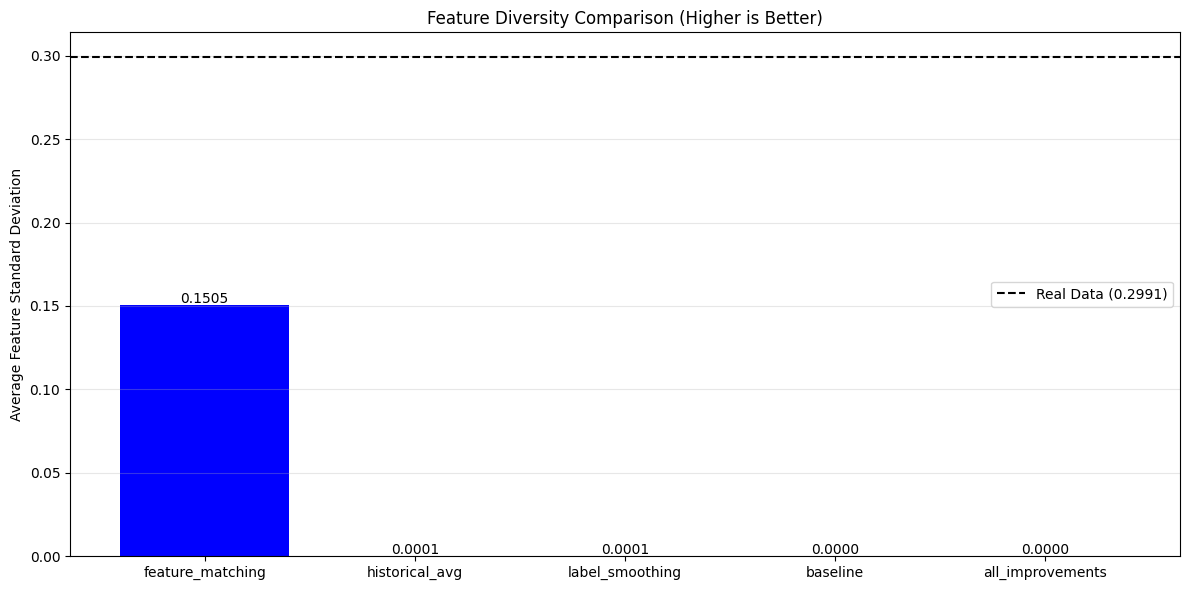


Mode Collapse Analysis:
--------------------------------------------------------------------------------
Configuration        Feature Std     % of Real       Mode Collapse  
--------------------------------------------------------------------------------
feature_matching     0.1505          50.31          % Moderate       
historical_avg       0.0001          0.03           % Severe         
label_smoothing      0.0001          0.02           % Severe         
baseline             0.0000          0.01           % Severe         
all_improvements     0.0000          0.01           % Severe         
--------------------------------------------------------------------------------
Real Data Reference: 0.2991
--------------------------------------------------------------------------------

Total experiment time: 86.68 minutes

=== Comprehensive Experiment Summary ===
Dataset: cifar10
Training epochs per configuration: 30
---------------------------------------------------------------------

In [28]:
results = run_complete_experiment(epochs=30)